In [ ]:
!pip install transformers
#!pip install wandb
!pip install easynmt
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install wordcloud
!pip install niacin

     |████████████████████████████████| 2.6 MB 7.6 MB/s 
     |████████████████████████████████| 636 kB 64.6 MB/s 
     |████████████████████████████████| 895 kB 72.3 MB/s 
     |████████████████████████████████| 3.3 MB 51.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 9.5 MB/s 
     |████████████████████████████████| 68 kB 5.6 MB/s 
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for easynmt: filename=EasyNMT-2.0.1-py3-none-any.whl size=15446 sha256=963fe26282654f3cc481a86bfeab17f427281253fcbf9a8167cb079694bc6dde
  Stored in directory: /root/.cache/pip/wheels/fb/42/fb/b7711d3296456d5f74e6e265dbdb0e3142158f1bb50382caef
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094969 sha256=528362d3acf68599d1f3a54a2d1858ff3e8c3aac37a49d58115fd34d1c6d2aa7
  Stored in directory

In [ ]:
!pip install plotly-orca

ERROR: Could not find a version that satisfies the requirement plotly-orca (from versions: none)
ERROR: No matching distribution found for plotly-orca


In [ ]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

In [ ]:
#print(torch.__version__)

In [ ]:
# needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
import time
#import wandb
import pickle
from easynmt import EasyNMT
import requests
import copy
import collections
from collections import defaultdict
from operator import itemgetter
import pickle
import string
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import plotly.express as px

import transformers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from transformers.models.bert.modeling_bert import BertEmbeddings, BertPooler, BertLayer
#import pytorch_lightning as pl
from sklearn.feature_extraction.text import CountVectorizer
from niacin.text import en

from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Use GPU
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Thu Aug 26 11:45:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get an Overview over the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data
data_loaded = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/kaggle_data.csv", names=['label', 'article'], encoding='latin-1')
data = data_loaded.copy()
print("Overall distribution of the data and labels:")
print(data['label'].value_counts(ascending=True))
print()
data.drop_duplicates()

all_lens = {
    'positive': [],
    'negative': [],
    'neutral': []
}

for index, row in data.iterrows():
    all_lens[row['label']].append(len(row['article']))
print("General dataset size: " + str(len(data)))

print("\nPositive Sentiment Mean Article Length: " + str(sum(all_lens['positive'])/len(all_lens['positive'])))
print("Positive Sentiment Max Article Length: " + str(max(all_lens['positive'])))
print()
print("Neutral Sentiment Mean Article Length: " + str(sum(all_lens['neutral'])/len(all_lens['neutral'])))
print("Neutral Sentiment Max Article Length: " + str(max(all_lens['neutral'])))
print()
print("Negative Sentiment Mean Article Length: " + str(sum(all_lens['negative'])/len(all_lens['negative'])))
print("Negative Sentiment Max Article Length: " + str(max(all_lens['negative'])))

Overall distribution of the data and labels:
negative     604
positive    1363
neutral     2879
Name: label, dtype: int64

General dataset size: 4846

Positive Sentiment Mean Article Length: 135.64783565663976
Positive Sentiment Max Article Length: 298

Neutral Sentiment Mean Article Length: 125.07224730809308
Neutral Sentiment Max Article Length: 315

Negative Sentiment Mean Article Length: 125.75662251655629
Negative Sentiment Max Article Length: 296


Text(0.5, 1.0, 'Dataset Sizes for each represented label')

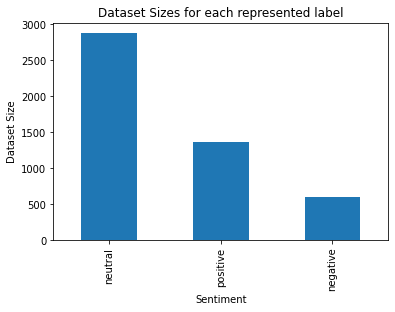

In [ ]:
# Plot data distribution
data['label'].value_counts().plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("Dataset Size")
plt.title("Dataset Sizes for each represented label")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/dataset_sizes_before_undersampling')

## Apply over and under sampling


negative    604
positive    604
neutral     604
Name: label, dtype: int64


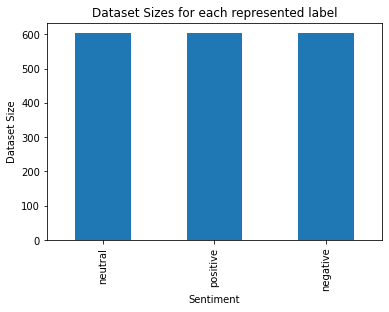

In [ ]:
count_dict = {
        'positive': len(data[data['label'] == 'positive']),
        'neutral': len(data[data['label'] == 'neutral']),
        'negative': len(data[data['label'] == 'negative'])
    }

# As we see in the plot above: underfit neutral to size of positive and oversample negative to size of positive
data_goal_size = data[data.label=='positive']
data_to_undersample1 = data[data.label=='positive']
data_to_undersample2 = data[data.label=='neutral']

data_undersampled1 = resample(data_to_undersample1, 
                            replace=False,
                            n_samples=count_dict['negative'],
                            random_state=1210)

data_undersampled2 = resample(data_to_undersample2, 
                              replace=True,
                              n_samples=count_dict['negative'],
                              random_state=1210)

# Concat dataframes
data = pd.concat([data[data['label'] == 'negative'], data_undersampled1, data_undersampled2])
data.reset_index(inplace=True, drop=True)

data['label'].value_counts().plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("Dataset Size")
plt.title("Dataset Sizes for each represented label")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/dataset_sizes_after_undersampling')
print(data['label'].value_counts(ascending=True))

## Have a look at the data

In [ ]:
print('Article:')
print(data.iloc[13].article + "\n")
print('Label:')
print(data.iloc[13].label)

Article:
23 April 2010 - Finnish construction and engineering company Outotec Oyj HEL : OTE1V said today it slipped to a net loss of EUR7 .3 m in the first quarter of 2010 from a net profit of EUR12 .5 m in the corresponding period last year .

Label:
negative


In [ ]:
label_names = list(set(data['label'].values))
label_names.sort()

print("All possible labels: " + str(label_names))

All possible labels: ['negative', 'neutral', 'positive']


### Test Data if BERT cased or uncased makes sense

In [ ]:
uppercased_words_found = []

for index, row in data.iterrows():
    temp_article = row['article']
    
    for word in temp_article:
        if len(word)>1 and word == word.upper():
            uppercased_words_found.append(word)
            
print(uppercased_words_found)

[]


## Preprocessing (@author: https://www.kaggle.com/madz2000/sentiment-analysis-cleaning-eda-bert-88-acc)

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
data['article']=data['article'].apply(remove_special_characters)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
    
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Apply function on review column
data['article']=data['article'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Wordclouds

### Overall

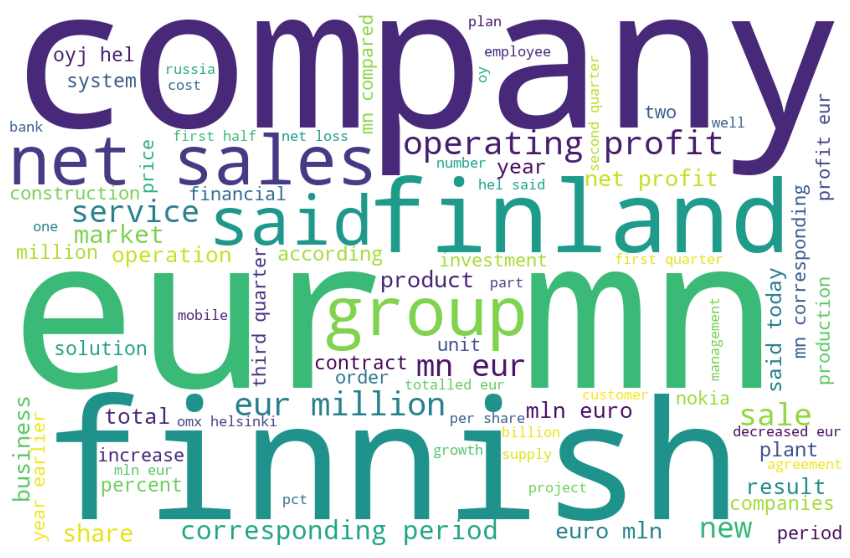

In [ ]:
words_collection = collections.Counter([item for item in data['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=80, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/wordcloud_general')
plt.show()

### Positive articles

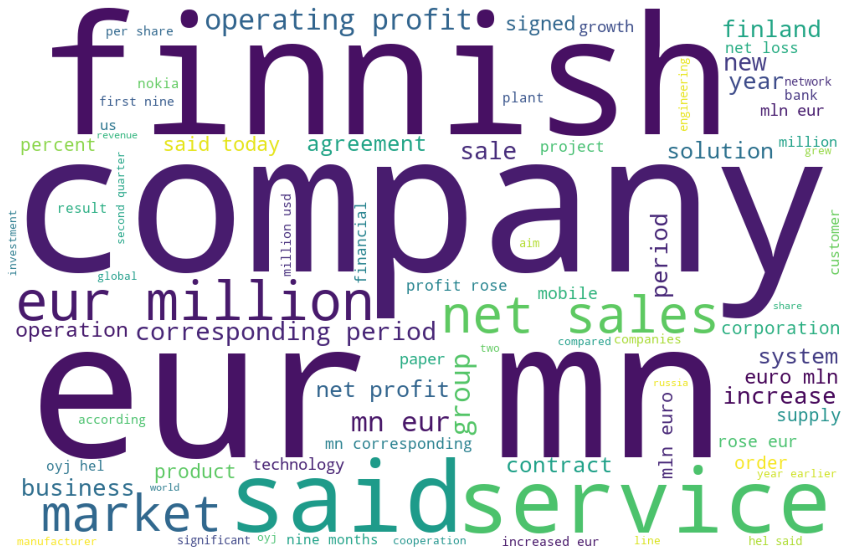

In [ ]:
positives = data[data['label'] == 'positive']

words_collection = collections.Counter([item for item in positives['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=80, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/wordcloud_positive')
plt.show()

### Neutral articles


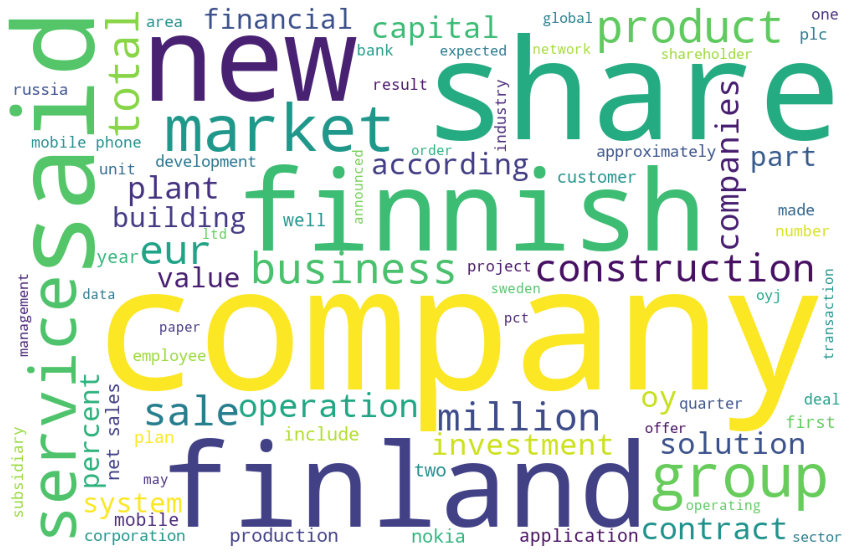

In [ ]:
neutrals = data[data['label'] == 'neutral']

words_collection = collections.Counter([item for item in neutrals['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=80, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/wordcloud_neutral')
plt.show()

### Negative articles

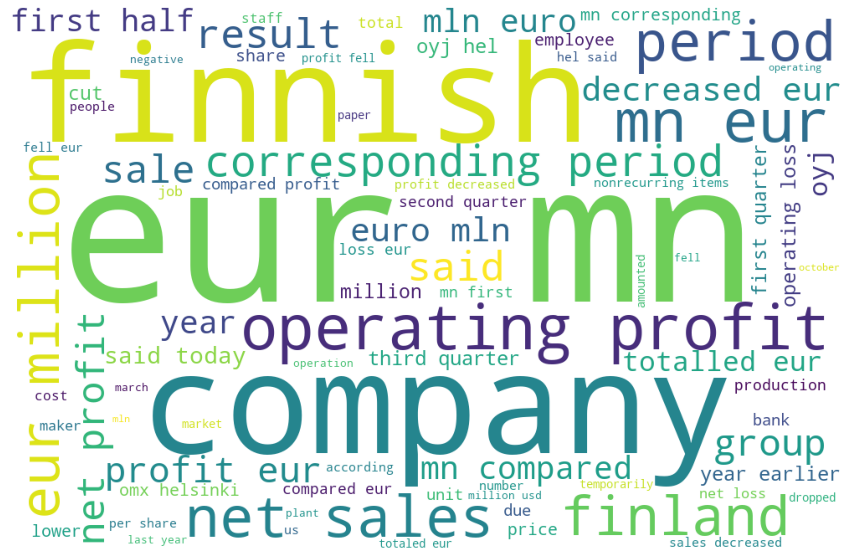

In [ ]:
negatives = data[data['label'] == 'negative']

words_collection = collections.Counter([item for item in negatives['article']])

word_string = " ".join(words_collection)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=80, 
                      width=1000,
                      height=650
                         ).generate(word_string)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/wordcloud_negative')
plt.show()

## Analyze distribution of review size in the context of positive or negative labels

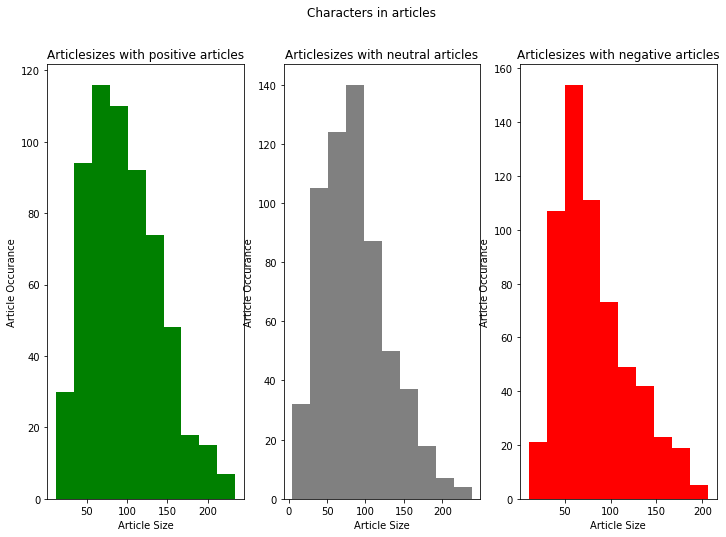

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))

text_len = data[data['label'] == 'positive']['article'].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Articlesizes with positive articles')
ax1.set_xlabel("Article Size")
ax1.set_ylabel("Article Occurance")

text_len = data[data['label'] == 'neutral']['article'].str.len()
ax2.hist(text_len, color='grey')
ax2.set_title('Articlesizes with neutral articles')
ax2.set_xlabel("Article Size")
ax2.set_ylabel("Article Occurance")

text_len = data[data['label'] == 'negative']['article'].str.len()
ax3.hist(text_len, color='red')
ax3.set_title('Articlesizes with negative articles')
ax3.set_xlabel("Article Size")
ax3.set_ylabel("Article Occurance")

fig.suptitle('Characters in articles')

#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/length_of_articles')
plt.show()

## Analyze most occuring Trigram -> three words pair occuring together in the same reqiew

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

most_common_tri = get_top_text_ngrams(data.article,20,3)
most_common_tri = dict(most_common_tri)

temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())

fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=1000, height=700,color='Common_words')
#fig.write_image(file='/content/drive/My Drive/Colab Notebooks/BA/trigram_uncleaned.png', format='.png')
fig.show()

### Delete words "mn", "mln" and "eur" from articles, as the amount is not important for sentiment and it reduces confusion about sentiments

In [ ]:
data['article']=data['article'].apply(lambda x: x.replace(" mn ", " ").replace(" eur ", " ").replace(" mln ", " "))

most_common_tri = get_top_text_ngrams(data.article,20,3)
most_common_tri = dict(most_common_tri)

temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())

fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=1000, height=700,color='Common_words')

#fig.savefig('/content/drive/My Drive/Colab Notebooks/BA/trigrams_cleaned')
fig.show()

## Convert labels to more understandable 0, 1, 2 format

In [ ]:
data.label.replace("positive" , 2 , inplace = True)
data.label.replace("neutral" , 1 , inplace = True)
data.label.replace("negative" , 0 , inplace = True)

## Build Pseudo Labeling Dataset

In [ ]:
# method to get exactly 50, 100, ... labeled data
def get_dataclass_distribution_of_unlabeled_data(data_class_size, X, y, random_state):
  labeled_data_distribution = data_class_size/len(X)

  X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=labeled_data_distribution, random_state=random_state, stratify=y)
  len(X_labeled)
  return {
      'labeled_data': X_labeled,
      'labeled_data_labels': y_labeled,
      'unlabeled_data': X_unlabeled,
      'unlabeled_data_labels': y_unlabeled
  }

## Set tokenizer

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
# Uncased -> Because case may express the sentiment but no uppercase word are given in the dataset as mentioned earlier

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Choose maximum token length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of all token lengths')

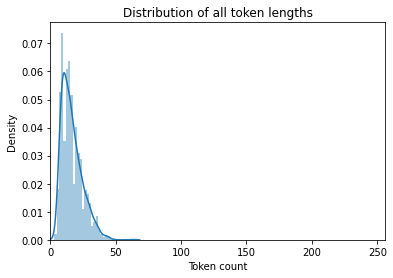

In [ ]:
token_lens = []
for txt in data.article:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')
plt.title("Distribution of all token lengths")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/BA/token_length')

In [ ]:
MAX_LEN = 70
BATCH_SIZE = 8
SEED = 1210

# Split data into training and validation datasets

In [ ]:

def split_data_into_train_test_val(X, y, val_size, random_state):
    X_reduced, X_test, y_reduced, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y_reduced, test_size=val_size, random_state=random_state, stratify=y_reduced)
    
    return {
        'train': {
            'X': list(X_train),
            'y': list(y_train)
        },
        'val': {
            'X': list(X_val),
            'y': list(y_val)
        },
        'test': {
            'X': list(X_test),
            'y': list(y_test)
        }
    }

In [ ]:
split_data = split_data_into_train_test_val(data['article'].values, data['label'].values, val_size=0.2, random_state=SEED)

In [ ]:
X_train = split_data['train']['X']
X_test = split_data['test']['X']
X_val = split_data['val']['X']
y_train = split_data['train']['y']
y_test = split_data['test']['y']
y_val = split_data['val']['y']

import collections, numpy



print("Distribution train: ")
print(collections.Counter(y_train))
print("\nDistribution val: ")
print(collections.Counter(y_val))
print("\nDistribution test: ")
print(collections.Counter(y_test))

Distribution train: 
Counter({0: 435, 2: 435, 1: 434})

Distribution val: 
Counter({0: 109, 1: 109, 2: 108})

Distribution test: 
Counter({2: 61, 1: 61, 0: 60})


### Build data class for pytorch-Dataloader usage (Map-style dataset)

In [ ]:
class BertData():
    def __init__(self, article, label):
        self.article = article
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.article)
    
    def __getitem__(self, idx):
        article = str(self.article[idx])
        article = ' '.join(article.split())

        inputs = self.tokenizer.encode_plus(
            article,
            None,
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding='max_length',
            truncation='longest_first'
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        labels = torch.tensor(self.label[idx], dtype=torch.long)

        return {'article': article,
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': labels
                }

In [ ]:
#training_set = BertData(article=X_train, label=y_train)
#validation_set = BertData(article=X_val, label=y_val)
#test_set = BertData(article=X_test, label=y_test)

### Set pytorch data loader

In [ ]:
def get_dataloader(training_set, validation_set, test_set):
    train_dataloader = DataLoader(
            training_set,
            batch_size=BATCH_SIZE, 
            shuffle=True
            )
    val_dataloader = DataLoader(
            validation_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    test_dataloader = DataLoader(
            test_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    
    return train_dataloader, val_dataloader, test_dataloader

# BERT Model

## Build PyTorch Pipeline

In [ ]:
#train_dataloader, val_dataloader, test_dataloader = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)

## Set Hyperparameters

In [ ]:
EPOCHS = 10
VALIDATION_SPLIT = 0.2
learning_rate = 3e-5

## Define standard BERT Classifier

In [ ]:
class ClassicalBertClassifier(nn.Module):
    def __init__(self):
        super(ClassicalBertClassifier, self).__init__()
        
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        #for param in self.bert.parameters():
         # param.requires_grad = False
        #self.drop = nn.Dropout(0.3)
        
#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          #nn.ReLU(),
   #         nn.Tanh(),
    #        nn.Dropout(0.3),
     #       nn.Linear(384, 128),
      #      nn.Tanh(),
       #     nn.Dropout(0.4),
        #    nn.Linear(128, 3)
       # )

#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          nn.ReLU(),
   #        nn.Dropout(0.5),
    #       nn.Linear(384, 3)
     #  )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(768, 3)
        )
        #self.all_targets = []


    def forward(self, input_ids, attention_mask, token_type_ids) -> torch.Tensor:
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    

# MixTest

## Define MixText BERT Classifier (According to publishers)

In [ ]:
class BertModel4Mix(transformers.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel4Mix, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder4Mix(config)
        self.pooler = BertPooler(config)

        self.init_weights()

    def _resize_token_embeddings(self, new_num_tokens):
        old_embeddings = self.embeddings.word_embeddings
        new_embeddings = self._get_resized_embeddings(
            old_embeddings, new_num_tokens)
        self.embeddings.word_embeddings = new_embeddings
        return self.embeddings.word_embeddings

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, input_ids,  input_ids2=None, l=None, mix_layer=1000, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):

        if attention_mask is None:
            if input_ids2 is not None:
                attention_mask2 = torch.ones_like(input_ids2)
            attention_mask = torch.ones_like(input_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
            if input_ids2 is not None:
                token_type_ids2 = torch.zeros_like(input_ids2)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        if input_ids2 is not None:

            extended_attention_mask2 = attention_mask2.unsqueeze(
                1).unsqueeze(2)

            extended_attention_mask2 = extended_attention_mask2.to(
                dtype=next(self.parameters()).dtype)  # fp16 compatibility
            extended_attention_mask2 = (
                1.0 - extended_attention_mask2) * -10000.0

        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = head_mask.unsqueeze(0).unsqueeze(
                    0).unsqueeze(-1).unsqueeze(-1)
                head_mask = head_mask.expand(
                    self.config.num_hidden_layers, -1, -1, -1, -1)
            elif head_mask.dim() == 2:
                # We can specify head_mask for each layer
                head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
            # switch to fload if need + fp16 compatibility
            head_mask = head_mask.to(dtype=next(self.parameters()).dtype)
        else:
            head_mask = [None] * self.config.num_hidden_layers

        embedding_output = self.embeddings(
            input_ids, position_ids=position_ids, token_type_ids=token_type_ids)

        if input_ids2 is not None:
            embedding_output2 = self.embeddings(
                input_ids2, position_ids=position_ids, token_type_ids=token_type_ids2)

        if input_ids2 is not None:
            encoder_outputs = self.encoder(embedding_output, embedding_output2, l, mix_layer,
                                           extended_attention_mask, extended_attention_mask2, head_mask=head_mask)
        else:
            encoder_outputs = self.encoder(
                embedding_output, attention_mask=extended_attention_mask, head_mask=head_mask)

        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        # add hidden_states and attentions if they are here
        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
        # sequence_output, pooled_output, (hidden_states), (attentions)
        return outputs

## Define BERT Encoder for Mix Test

In [ ]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class BertEncoder4Mix(nn.Module):
    def __init__(self, config):
        super(BertEncoder4Mix, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config)
                                    for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, hidden_states2=None, l=None, mix_layer=1000, attention_mask=None, attention_mask2=None, head_mask=None):
        all_hidden_states = ()
        all_attentions = ()

        # Perform mix at till the mix_layer
        if mix_layer == -1:
            if hidden_states2 is not None:
                hidden_states = l * hidden_states + (1-l)*hidden_states2

        for i, layer_module in enumerate(self.layer):
            if i <= mix_layer:

                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

                if hidden_states2 is not None:
                    layer_outputs2 = layer_module(
                        hidden_states2, attention_mask2, head_mask[i])
                    hidden_states2 = layer_outputs2[0]

            if i == mix_layer:
                if hidden_states2 is not None:
                    hidden_states = l * hidden_states + (1-l)*hidden_states2

            if i > mix_layer:
                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        # last-layer hidden state, (all hidden states), (all attentions)
        return outputs


## Define Mix Test

In [ ]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class MixText(nn.Module):
    def __init__(self, num_labels=3, mix_option=False):
        super(MixText, self).__init__()

        if mix_option:
            self.bert = BertModel4Mix.from_pretrained('bert-base-uncased')
        else:
            self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.linear = nn.Sequential(nn.Linear(768, 128),
                                    nn.Tanh(),
                                    nn.Linear(128, num_labels))

    def forward(self, x, x2=None, l=None, mix_layer=1000):

        if x2 is not None:
            all_hidden, pooler = self.bert(x, x2, l, mix_layer)

            pooled_output = torch.mean(all_hidden, 1)

        else:
            all_hidden, pooler = self.bert(x)

            pooled_output = torch.mean(all_hidden, 1)

        predict = self.linear(pooled_output)

        return predict

## Define Mix Validate

In [ ]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
def mix_validate(valloader, model, criterion, epoch, mode):
    model.eval()
    with torch.no_grad():
        loss_total = 0
        total_sample = 0
        correct = 0
        overall_targets = []
        overall_preds = []

        for batch_idx, (inputs, targets, length) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)

            if batch_idx == 0:
                print("Sample some true labeles and predicted labels")
                print(predicted[:20])
                print(targets[:20])

            new_targets = [int(target) for target in targets]
            overall_targets = overall_targets + new_targets

            new_preds = [int(pred) for pred in predicted]
            overall_preds = overall_preds + new_preds

            loss_total += loss.item() * inputs.shape[0]
            total_sample += inputs.shape[0]

        loss_total = loss_total/total_sample
        
    accuracy = accuracy_score(overall_targets, overall_preds)
    precision = precision_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
    recall = recall_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
    f1 = f1_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))

    frequency = {}

    # iterating over the list
    for item in overall_preds:
    # checking the element in dictionary
      if item in frequency:
        # incrementing the count
        frequency[item] += 1
      else:
      # initializing the count
        frequency[item] = 1

    frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))

    return loss_total, accuracy, precision, recall, f1, frequency, overall_targets, overall_preds

def linear_rampup(current, rampup_length=EPOCHS):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

## Define translation model for MixText augmentation

In [ ]:
from easynmt import EasyNMT
#TRANSLATION_MODEL = EasyNMT('mbart50_m2m') # von Facebook reasearch
TRANSLATION_MODEL = EasyNMT('opus-mt', device=device) # smaller model -> worse performance - better runtime

100%|██████████| 11.9k/11.9k [00:00<00:00, 8.03MB/s]


## Pre translate all possible input texts to increase training speed for MixText

In [ ]:

txt = data['article'].iloc[24]
print(txt)
print()
print(en.add_backtranslation(txt, p=0.01))

company profit taxes fell third quarter compared corresponding period

company profit taxes fell third quarter compared corresponding period


In [ ]:
#synonym_augment_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: en.add_synonyms(article, p=0.01) for article in data_loaded['article']}
#fat_thumbs_augment_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: en.add_fat_thumbs(article, p=0.01) for article in data_loaded['article']}
#german_translate_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='de', source_lang='en'), target_lang='en', source_lang='de') for article in data_loaded['article']}
#russian_translate_dict = {data_loaded.index[data_loaded['article'] == article].tolist()[0]: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='ru', source_lang='en'), target_lang='en', source_lang='ru') for article in data_loaded['article']}

In [ ]:
def save_translator_dicts():
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'wb') as f:
    pickle.dump(german_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'wb') as f:
    pickle.dump(russian_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/synonym_augment_dict.pickle', 'wb') as f:
    pickle.dump(synonym_augment_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/fat_thumbs_augment_dict.pickle', 'wb') as f:
    pickle.dump(fat_thumbs_augment_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_translator_dicts():
  #with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'rb') as f:
   # ger_translate_dict = pickle.load(f)

  #with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'rb') as f:
   # rus_translate_dict = pickle.load(f)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/synonym_augment_dict.pickle', 'rb') as f:
    synonym_augment_dict = pickle.load(f)

  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/fat_thumbs_augment_dict.pickle', 'rb') as f:
    fat_thumbs_augment_dict = pickle.load(f)

  return synonym_augment_dict, fat_thumbs_augment_dict
#save_translator_dicts()
synonym_augment_dict, fat_thumbs_augment_dict = load_translator_dicts()

## Define Loss for Mix Test

In [ ]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, outputs_u_2, epoch, mixed=1):
        temp_change = 1000000
        T = 0.5
        co = False
        alpha = 0.75
        seperate_mix = False
        mix_layers_set = [7, 9, 12]
        mix_method = 0
        margin = 0.7
        lambda_u_hinge = 1
        lambda_u = 1

        if mix_method == 0 or mix_method == 1:

            Lx = - \
                torch.mean(torch.sum(F.log_softmax(
                    outputs_x, dim=1) * targets_x, dim=1))

            probs_u = torch.softmax(outputs_u, dim=1)

            Lu = F.kl_div(probs_u.log(), targets_u, None, None, 'batchmean')

            Lu2 = torch.mean(torch.clamp(torch.sum(-F.softmax(outputs_u, dim=1)
                                                   * F.log_softmax(outputs_u, dim=1), dim=1) - margin, min=0))

        elif mix_method == 2:
            if mixed == 0:
                Lx = - \
                    torch.mean(torch.sum(F.logsigmoid(
                        outputs_x) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)

                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u_2, dim=1) * F.softmax(outputs_u_2, dim=1), dim=1), min=0))
            else:
                Lx = - \
                    torch.mean(torch.sum(F.log_softmax(
                        outputs_x, dim=1) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)
                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u, dim=1) * F.softmax(outputs_u, dim=1), dim=1), min=0))

        return Lx, Lu, lambda_u * linear_rampup(epoch), Lu2, lambda_u_hinge * linear_rampup(epoch)


## Define loaders for MixText

In [ ]:
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [7, 9, 12]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
lambda_u = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

# define augmentation translator 
class Translator:
    """Backtranslation. Here to save time, we pre-processing and save all the translated data into pickle files.
    """

    def __init__(self, path, transform_type='BackTranslation'):
        # Translator for eng to de to eng
        # self.translator = TRANSLATION_MODEL
        self.translator = None

    def __call__(self, ori):
      return synonym_augment_dict[data.index[data['article'] == ori].tolist()[0]], fat_thumbs_augment_dict[data.index[data['article'] == ori].tolist()[0]], ori
        
class mixtext_loader_labeled():
    # Data loader for labeled data
    def __init__(self, dataset_text, dataset_label, tokenizer, max_seq_len, aug=False):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.labels = dataset_label
        self.max_seq_len = max_seq_len

        self.aug = aug
        self.trans_dist = {}

    def __len__(self):
        return len(self.labels)

    def augment(self, text):
        if text not in self.trans_dist:
            self.trans_dist[text] = synonym_augment_dict[data.index[data['article'] == text].tolist()[0]]
        return self.trans_dist[text]

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)

        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding

        return encode_result, length

    def __getitem__(self, idx):
        if self.aug:
            text = self.text[idx]
            text_aug = self.augment(text)
            text_result, text_length = self.get_tokenized(text)
            text_result2, text_length2 = self.get_tokenized(text_aug)
            return ((torch.tensor(text_result), torch.tensor(text_result2).to(device)), (self.labels[idx], self.labels[idx]), (text_length, text_length2))
        else:
            text = self.text[idx]
            tokens = self.tokenizer.tokenize(text)
            if len(tokens) > self.max_seq_len:
                tokens = tokens[:self.max_seq_len]
            length = len(tokens)
            encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
            padding = [0] * (self.max_seq_len - len(encode_result))
            encode_result += padding
            return (torch.tensor(encode_result), self.labels[idx], length)


class mixtext_loader_unlabeled():
    # Data loader for unlabeled data
    def __init__(self, dataset_text, tokenizer, max_seq_len, aug=None):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.ids = [n for n in range (0, len(dataset_text)+1)]
        self.aug = aug
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.text)

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)
        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding
        return encode_result, length

    def __getitem__(self, idx):
        if self.aug is not None:
            u, v, ori = self.aug(self.text[idx])
            encode_result_u, length_u = self.get_tokenized(u)
            encode_result_v, length_v = self.get_tokenized(v)
            encode_result_ori, length_ori = self.get_tokenized(ori)
            return ((torch.tensor(encode_result_u), torch.tensor(encode_result_v), torch.tensor(encode_result_ori)), (length_u, length_v, length_ori))
        else:
            text = self.text[idx]
            encode_result, length = self.get_tokenized(text)
            return (torch.tensor(encode_result), length)

## Set up MixTest default parameters setp up by the publishers

In [ ]:
# recommended default sets by publisher of MixText
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [0, 1, 2, 3]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

### Training

## Define traditional eval epoch

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  pseudo_labels = []

  overall_targets = []
  overall_preds = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids)
      
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      new_targets = [float(target) for target in targets]
      overall_targets = overall_targets + new_targets

      new_preds = [float(pred) for pred in preds]
      overall_preds = overall_preds + new_preds

      for item in preds:
        pseudo_labels.append(item.item())
  frequency = {}

  # iterating over the list
  for item in pseudo_labels:
  # checking the element in dictionary
    if item in frequency:
      # incrementing the count
      frequency[item] += 1
    else:
    # initializing the count
      frequency[item] = 1
  
  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  recall = recall_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))
  f1 = f1_score(overall_targets, overall_preds, average='macro', labels=np.unique(overall_preds))


  frequency = dict(sorted(frequency.items(), key=lambda item: item[1]))

  return accuracy, precision, recall, f1, np.mean(losses), frequency, overall_targets, overall_preds

## Overall Training loop

#### Build function to save results to excel each fold

In [ ]:
def save_results_to_excel(saving_dict, fold, dataclass):
  data_test = [{
              'fold': fold,
              'model': kind,
              'test_acc': saving_dict[kind]['test']['acc'],
              'test_precision': saving_dict[kind]['test']['precision'],
              'test_recall': saving_dict[kind]['test']['recall'],
              'test_f1': saving_dict[kind]['test']['f1'],
              'test_loss': saving_dict[kind]['test']['loss'],
              'train_time': saving_dict[kind]['time'],
              'frequency of precited labels': str(saving_dict[kind]['freq'])
          } for kind in list(saving_dict.keys())]

  for kind in list(saving_dict.keys()):
    list_to_df = [{
        'epoch': epoch+1,
        'model': kind,
        'train_acc': saving_dict[kind]['hist']['train_acc'][epoch],
        'train_precision': saving_dict[kind]['hist']['train_precision'][epoch],
        'train_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'train_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'train_loss': saving_dict[kind]['hist']['train_loss'][epoch],
        'val_acc': saving_dict[kind]['hist']['val_acc'][epoch],
        'val_precision': saving_dict[kind]['hist']['val_precision'][epoch],
        'val_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'val_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'val_loss': saving_dict[kind]['hist']['val_loss'][epoch]
      } for epoch in range(EPOCHS)] 

    df_to_safe = pd.DataFrame(list_to_df)
    df_to_safe.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/histories/data_classes/{data_class}/fold_{1}/{kind}/training_data_from_fold.xlsx")

  df_test = pd.DataFrame(data_test)

  # to excel
  df_test.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/class_{data_class}_test_data_from_fold_{fold}.xlsx")

## Evalutation Methods

In [ ]:
from sklearn import datasets, metrics, model_selection, svm

def build_confusion_matrix(confusion_matrix, kind, data_class):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  plt.title(f'Confusion Matrix {kind} (dataclass: {data_class})');
  plt.savefig(f'/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/confusion_matrix_dataclass_{data_class}_{kind}')
  plt.clf()

def plot_roc_curve(y_true, y_pred, kind, data_class):
  fig = plt.figure(plt.plot([0, 1], [0, 1], color='navy', linestyle='--'))

  for i in range(y_true.shape[1]):
    ax = fig.add_subplot()

    y_tru = y_true.iloc[:, i]
    y_score = y_pred[:, i]

    fpr, tpr, _ = metrics.roc_curve(y_tru,  y_score)
    auc_score = metrics.roc_auc_score(y_tru, y_score)

    ax.plot(fpr,tpr)

  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  plt.title(f'ROC Curve {kind} (dataclass: {data_class})');
  plt.savefig(f'/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/ROC_Curve{data_class}_{kind}')
  plt.clf()


### Loop itself

In [ ]:
from transformers import logging

logging.set_verbosity_error()
    
FOLDS = 10
RANDOM_STATES = ['1210', '505', '2506', '1807', '1402', '107', '1803', '2405', '208', '2209']

overall_saving_dict = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}

best_models = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}


test_txt_string = ""

total_steps = 0
flag = 0
BATCH_SIZE = 8

# set reasonable data manipulation classes
data_manipultation_classes = [10, 50, 250, 500, 1300]

# Calculate weights for cross entropy loss // Formula: Maximum label occurance / occurance of label
count_dict = {
        'positive': len(data[data['label'] == 2]),
        'neutral': len(data[data['label'] == 1]),
        'negative': len(data[data['label'] == 0])
    }

print(count_dict)

weights_for_cross_entropy_loss = [(count_dict['neutral']/count_dict['negative']), (count_dict['neutral']/count_dict['neutral']), (count_dict['neutral']/count_dict['positive'])]
weights_for_cross_entropy_loss = torch.FloatTensor(weights_for_cross_entropy_loss).to(device)

for data_class in data_manipultation_classes:
  cm1 = None
  cm2 = None
  cm3 = None
  cm4 = None
  tradi_overall_matrix = None
  nssdl_overall_matrix = None
  nssdl_strong_overall_matrix = None
  mixtext_overall_matrix = None

  for fold in range(10):
    print("Data class of " + str(data_class) + " labeled samples per fold")
    print('-' * 50)
    print()

    # clear CUDA memory
    tradi_model = None
    NSSDL_model = None
    NSSDL_strong_model = None
    MixText_model = None

    torch.cuda.empty_cache() 

    # set random_state
    random_state = int(str(data_manipultation_classes.index(data_class)+1) + RANDOM_STATES[0])

    # set labeled- and unlabeled data and train-, val-, test data
    split_data = split_data_into_train_test_val(data['article'], data['label'], 0.2, random_state)

    X_train = split_data['train']['X']
    X_test = split_data['test']['X']
    X_val = split_data['val']['X']

    y_train = split_data['train']['y']
    y_test = split_data['test']['y']
    y_val = split_data['val']['y']

    data_dict = get_dataclass_distribution_of_unlabeled_data(data_class_size=data_class,
                                                              X=X_train, 
                                                              y=y_train, 
                                                              random_state=random_state)
    
    X_train_labeled = data_dict['labeled_data']
    X_train_unlabeled = data_dict['unlabeled_data']

    y_train_labeled = data_dict['labeled_data_labels']

    frequency = {}

    # iterating over the list
    for item in y_train_labeled:
    # checking the element in dictionary
      if item in frequency:
        # incrementing the count
        frequency[item] += 1
      else:
      # initializing the count
        frequency[item] = 1

    print(f"initial distribution: {frequency}")

    # initialise BertData
    training_set = BertData(article=X_train_labeled, label=y_train_labeled)
    validation_set = BertData(article=X_val, label=y_val)
    test_set = BertData(article=X_test, label=y_test)

    # initialize dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloader(training_set, 
                                                                        validation_set, 
                                                                        test_set)
    
    tradi_loss_fn = nn.CrossEntropyLoss().to(device)
    nssdl_loss_fn = nn.CrossEntropyLoss().to(device)
    nssdl_strong_loss_fn = nn.CrossEntropyLoss().to(device)
    mixtext_loss_fn = nn.CrossEntropyLoss().to(device)

    total_steps = len(train_dataloader) * EPOCHS

    # get state dicts
    loaded_tradi = torch.load(f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_1/tradi_best_model_state.pt')
    loaded_nssdl = torch.load(f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_1/NSSDL_best_model_state.pt')
    loaded_nssdl_strong = torch.load(f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_1/NSSDL Strong_best_model_state.pt')
    loaded_mixtext = torch.load(f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_1/MixText_best_model_state.pt')
    
    # traditional
    tradi_model = ClassicalBertClassifier()
    tradi_model = tradi_model.to(device)
    tradi_model.load_state_dict(loaded_tradi)

    tradi_test_acc, tradi_test_precision, tradi_test_recall, tradi_test_f1, tradi_test_loss, tradi_frequency_test, tradi_overall_targets, tradi_overall_preds = eval_model(
      tradi_model,
      test_dataloader,
      tradi_loss_fn,
      device,
      len(validation_set))
    

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = NSSDL_model.to(device)
    NSSDL_model.load_state_dict(loaded_nssdl)

    nssdl_test_acc, nssdl_test_precision, nssdl_test_recall, nssdl_test_f1, nssdl_test_loss, nssdl_frequency_test, nssdl_overall_targets, nssdl_overall_preds = eval_model(
      NSSDL_model,
      test_dataloader,
      nssdl_loss_fn,
      device,
      len(validation_set))
    
    NSSDL_Strong_model = ClassicalBertClassifier()
    NSSDL_Strong_model = NSSDL_Strong_model.to(device)
    NSSDL_Strong_model.load_state_dict(loaded_nssdl_strong)

    nssdl_strong_test_acc, nssdl_strong_test_precision, nssdl_strong_test_recall, nssdl_strong_test_f1, nssdl_strong_test_loss, nssdl_strong_frequency_test, nssdl_strong_overall_targets, nssdl_strong_overall_preds = eval_model(
      NSSDL_Strong_model,
      test_dataloader,
      nssdl_strong_loss_fn,
      device,
      len(validation_set))
    
    MixText_model = MixText(num_labels=3, mix_option=True)
    MixText_model = nn.DataParallel(MixText_model)
    MixText_model = MixText_model.to(device)
    MixText_model.load_state_dict(loaded_mixtext)

    mix_text_loader = DataLoader(
            dataset=mixtext_loader_labeled(
                dataset_text=X_test,
                dataset_label=y_test, 
                tokenizer=tokenizer, 
                max_seq_len=MAX_LEN
                ),
            batch_size=BATCH_SIZE, 
            shuffle=True)


    mixtext_test_loss, mixtext_test_acc, mixtext_test_precision, mixtext_test_recall, mixtext_test_f1, mixtext_frequency_test, mixtext_overall_targets, mixtext_overall_preds = mix_validate(
      mix_text_loader,
      MixText_model,
      mixtext_loss_fn,
      11,
      mode='Test Stats')
    
    cm1 = confusion_matrix(tradi_overall_targets, tradi_overall_preds)
    cm2 = confusion_matrix(nssdl_overall_targets, nssdl_overall_preds)
    cm3 = confusion_matrix(nssdl_strong_overall_targets, nssdl_strong_overall_preds)
    cm4 = confusion_matrix(mixtext_overall_targets, mixtext_overall_preds)
    
    if tradi_overall_matrix is None:
      tradi_overall_matrix = cm1
    else:
      tradi_overall_matrix = np.add(tradi_overall_matrix, cm1)
    if nssdl_overall_matrix is None:
      nssdl_overall_matrix = cm2
    else:
      nssdl_overall_matrix = np.add(tradi_overall_matrix, cm2)
    if nssdl_strong_overall_matrix is None:
      nssdl_strong_overall_matrix = cm3
    else:
      nssdl_strong_overall_matrix = np.add(tradi_overall_matrix, cm3)
    if mixtext_overall_matrix is None:
      mixtext_overall_matrix = cm4
    else:
      mixtext_overall_matrix = np.add(tradi_overall_matrix, cm4)
    
  

  cm1 = tradi_overall_matrix / 10
  cm1 = cm1.astype(int)
  df_cm1 = pd.DataFrame(cm1, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
  build_confusion_matrix(df_cm1, 'Traditional', data_class)

  cm2 = nssdl_overall_matrix / 10
  cm2 = cm2.astype(int)
  df_cm2 = pd.DataFrame(cm2, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
  build_confusion_matrix(df_cm2, 'NSSDL', data_class)

  cm3 = nssdl_strong_overall_matrix / 10
  cm3 = cm3.astype(int)
  df_cm3 = pd.DataFrame(cm3, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
  build_confusion_matrix(df_cm3, 'NSSDL Strong', data_class)

  cm4 = mixtext_overall_matrix / 10
  cm4 = cm4.astype(int)
  df_cm4 = pd.DataFrame(cm4, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
  build_confusion_matrix(df_cm4, 'MixText', data_class)


  # ROC Cruves
#  plot_roc_curve(tradi_overall_targets, tradi_overall_preds, 'Traditional', data_class)
#  plot_roc_curve(nssdl_overall_targets, nssdl_overall_preds, 'NSSDL', data_class)
#  plot_roc_curve(nssdl_strong_overall_targets, nssdl_strong_overall_preds, 'NSSDL Strong', data_class)
#  plot_roc_curve(mixtext_overall_targets, mixtext_overall_preds, 'MixText', data_class)
    

{'positive': 604, 'neutral': 604, 'negative': 604}
Data class of 10 labeled samples per fold
--------------------------------------------------

initial distribution: {0: 3, 1: 3, 2: 4}
Sample some true labeles and predicted labels
tensor([2, 2, 2, 2, 2, 1, 2, 2], device='cuda:0')
tensor([0, 1, 1, 2, 1, 1, 2, 1], device='cuda:0')
Data class of 10 labeled samples per fold
--------------------------------------------------

initial distribution: {0: 3, 1: 3, 2: 4}
Sample some true labeles and predicted labels
tensor([2, 2, 2, 2, 1, 2, 2, 2], device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 2], device='cuda:0')
Data class of 10 labeled samples per fold
--------------------------------------------------

initial distribution: {0: 3, 1: 3, 2: 4}
Sample some true labeles and predicted labels
tensor([2, 2, 2, 2, 2, 2, 1, 2], device='cuda:0')
tensor([2, 1, 2, 2, 2, 1, 1, 0], device='cuda:0')
Data class of 10 labeled samples per fold
--------------------------------------------------

initial dist

<Figure size 432x288 with 0 Axes>

In [ ]:
# empty cuda cache
tradi_model = None
NSSDL_model = None
NSSDL_strong_model = None
MixText_model = None

torch.cuda.empty_cache() 